Copyright (C) 2025 Advanced Micro Devices, Inc. All rights reserved.
Portions of this notebook consist of AI-generated content.

Permission is hereby granted, free of charge, to any person obtaining a copy

of this software and associated documentation files (the "Software"), to deal

in the Software without restriction, including without limitation the rights

to use, copy, modify, merge, publish, distribute, sublicense, and/or sell

copies of the Software, and to permit persons to whom the Software is

furnished to do so, subject to the following conditions:



The above copyright notice and this permission notice shall be included in all

copies or substantial portions of the Software.



THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR

IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,

FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE

AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER

LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,

OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE

SOFTWARE.

# CV02 ResNet

### Lab Description

This laboratory exercise introduces **ResNet-50**, a deep residual neural network widely used for large-scale image classification. Residual connections help train very deep networks by alleviating vanishing gradients and enabling efficient feature reuse.

In this hands-on lab, you will train a ResNet-50 classifier on the `CIFAR-100` dataset, monitor the training process through loss/accuracy curves, and evaluate the model on a held-out test set.

### What you can expect to learn

- **Theoretical Understanding**: Understand residual learning, identity shortcuts, and how deep networks benefit from skip connections.  
- **Implementation of ResNet-50**: Use torchvision’s ResNet-50, adapt the final classification layer for 100 classes, and set up a robust training loop in PyTorch.  
- **Training & Monitoring**: Track per-epoch time, batch size, and VRAM usage; observe convergence through training/validation loss and accuracy (Top-1/Top-5).  
- **Visualization & Evaluation**:  
  - Plot training curves (loss & accuracy) to verify learning progress.  
  - Inspect sample predictions to qualitatively assess performance.  
  - Report final metrics on the test set and export per-epoch statistics (CSV/logs).


In [1]:
import sys

import torch
import torchvision

print("Python:", sys.version.split()[0])
print("PyTorch:", torch.__version__)
print("Torchvision:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))

Python: 3.12.11
PyTorch: 2.8.0+rocm6.4
Torchvision: 0.23.0+rocm6.4
CUDA available: True
CUDA device: AMD Radeon AI PRO R9700


## 1. Import necessary libraries

In [2]:
import math
import os
import random
import time
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as T
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import models
from torchvision.datasets import CIFAR100


@dataclass
class CFG:
    seed: int = 42
    batch_size: int = 128
    epochs: int = 30
    lr: float = 1e-3
    weight_decay: float = 5e-4
    num_classes: int = 100
    img_size: int = 32  # CIFAR images are 32x32
    device: str = "cuda" if torch.cuda.is_available() else "cpu"


cfg = CFG()

# Base dirs
DATA_DIR = os.path.expanduser("~/data")
OUTPUT_DIR = os.path.expanduser("~/data/resnet50_cifar100_outputs")
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("DATA_DIR:", DATA_DIR)
print("OUTPUT_DIR:", OUTPUT_DIR)


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


set_seed(cfg.seed)
cfg

DATA_DIR: /home/aup/data
OUTPUT_DIR: /home/aup/data/resnet50_cifar100_outputs


CFG(seed=42, batch_size=128, epochs=30, lr=0.001, weight_decay=0.0005, num_classes=100, img_size=32, device='cuda')

## 2. Required Dataset
We use standard `CIFAR-100` normalization and basic augmentations for the training set.

- **Mean**: `[0.5071, 0.4867, 0.4408]`  
- **Std** : `[0.2675, 0.2565, 0.2761]`


In [3]:
# CIFAR-100 stats
CIFAR100_MEAN = (0.5071, 0.4867, 0.4408)
CIFAR100_STD = (0.2675, 0.2565, 0.2761)

train_tfms = T.Compose(
    [
        T.RandomCrop(cfg.img_size, padding=4),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(CIFAR100_MEAN, CIFAR100_STD),
    ]
)

test_tfms = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(CIFAR100_MEAN, CIFAR100_STD),
    ]
)

train_set = CIFAR100(root=DATA_DIR, train=True, download=True, transform=train_tfms)
test_set = CIFAR100(root=DATA_DIR, train=False, download=True, transform=test_tfms)

# Split out a small validation set from training (e.g., 5k images)
val_size = 5000
train_size = len(train_set) - val_size
train_set, val_set = torch.utils.data.random_split(
    train_set, [train_size, val_size], generator=torch.Generator().manual_seed(cfg.seed)
)

train_loader = DataLoader(
    train_set, batch_size=cfg.batch_size, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available()
)
val_loader = DataLoader(
    val_set, batch_size=cfg.batch_size, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available()
)
test_loader = DataLoader(
    test_set, batch_size=cfg.batch_size, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available()
)

len(train_set), len(val_set), len(test_set)

(45000, 5000, 10000)

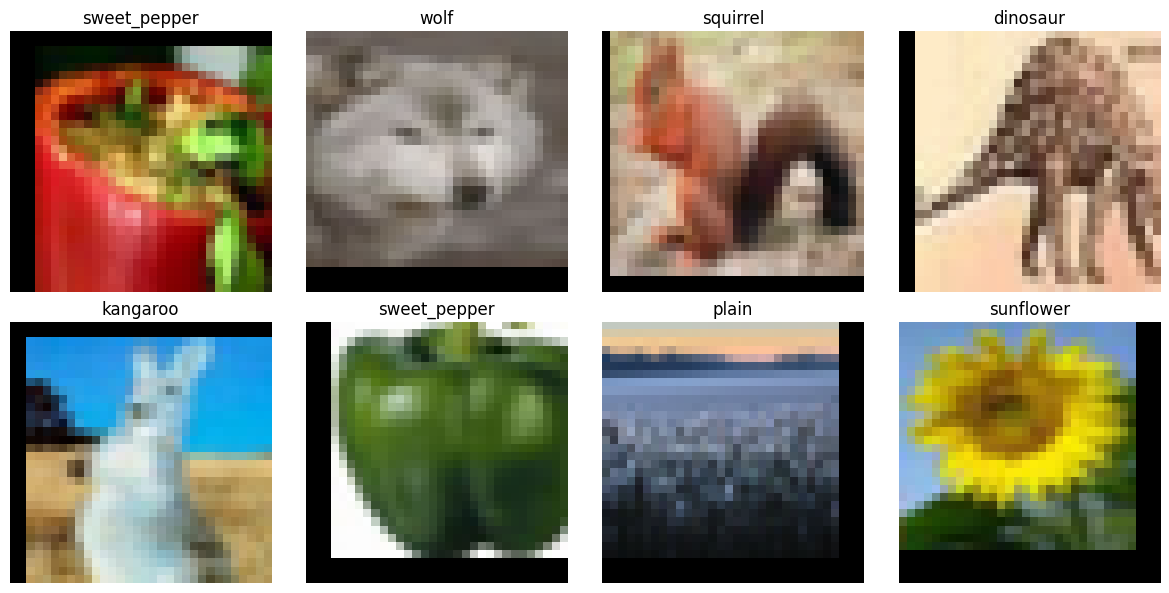

In [4]:
# Get CIFAR-100 class names
classes = CIFAR100(root=DATA_DIR, train=False, download=False).classes


# Undo normalization function
def denormalize(img):
    mean = np.array(CIFAR100_MEAN).reshape(3, 1, 1)
    std = np.array(CIFAR100_STD).reshape(3, 1, 1)
    img = img * std + mean
    return np.clip(img, 0, 1)


# Fetch one batch
images, targets = next(iter(train_loader))

n_show = min(8, images.size(0))  # show up to 8 samples
plt.figure(figsize=(12, 6))
for i in range(n_show):
    img = denormalize(images[i].numpy())
    plt.subplot(2, 4, i + 1)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(classes[targets[i].item()])
    plt.axis("off")
plt.tight_layout()
plt.show()

## 3. Model: ResNet-50
- Use torchvision’s `resnet50` with output dimension `num_classes=100`.  
- For simplicity, we train from scratch (no ImageNet weights).

In [5]:
device = torch.device(cfg.device)

model = models.resnet50(weights=None)  # train from scratch
# Replace the final fully-connected layer for CIFAR-100
model.fc = nn.Linear(model.fc.in_features, cfg.num_classes)

model = model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## 4. Loss, Optimizer, and (Optional) Scheduler
- **CrossEntropyLoss** for classification.  
- **Adam** optimizer with weight decay.  
- Scheduler is optional; here we use a CosineAnnealingLR for smoother training.


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.epochs)

## 5. Utilities
We implement helper functions:
- `accuracy` for top-1 (and top-5)  
- `train_one_epoch` and `validate` to compute losses/metrics  
- GPU peak memory tracking per epoch


In [7]:
def accuracy(logits, targets, topk=(1,)):
    """Compute top-k accuracy (%)."""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = targets.size(0)
        _, pred = logits.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(targets.view(1, -1).expand_as(pred))
        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append((correct_k.mul_(100.0 / batch_size)).item())
        return res


def gpu_reset_peaks():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()


def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, running_top1, running_top5, n_samples = 0.0, 0.0, 0.0, 0
    for images, targets in loader:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(images)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()

        bs = images.size(0)
        top1, top5 = accuracy(logits, targets, topk=(1, 5))
        running_loss += loss.item() * bs
        running_top1 += top1 * bs / 100.0
        running_top5 += top5 * bs / 100.0
        n_samples += bs

    return (running_loss / n_samples, 100.0 * running_top1 / n_samples, 100.0 * running_top5 / n_samples)


@torch.no_grad()
def validate(model, loader, criterion, device):
    model.eval()
    running_loss, running_top1, running_top5, n_samples = 0.0, 0.0, 0.0, 0
    for images, targets in loader:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        logits = model(images)
        loss = criterion(logits, targets)

        bs = images.size(0)
        top1, top5 = accuracy(logits, targets, topk=(1, 5))
        running_loss += loss.item() * bs
        running_top1 += top1 * bs / 100.0
        running_top5 += top5 * bs / 100.0
        n_samples += bs

    return (running_loss / n_samples, 100.0 * running_top1 / n_samples, 100.0 * running_top5 / n_samples)

## 6. Training Loop


In [8]:
epoch_times, peak_vram_per_epoch = [], []
train_losses, train_top1s, train_top5s = [], [], []
val_losses, val_top1s, val_top5s = [], [], []

log_path = os.path.join(OUTPUT_DIR, "log.txt")
with open(log_path, "w") as f:
    f.write("epoch,batch_size,lr,time(s),train_loss,train_top1,train_top5,val_loss,val_top1,val_top5,peak_vram(MB)\n")

for epoch in range(1, cfg.epochs + 1):
    gpu_reset_peaks()
    t0 = time.perf_counter()

    tr_loss, tr_top1, tr_top5 = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, v_top1, v_top5 = validate(model, val_loader, criterion, device)

    # scheduler step after val
    scheduler.step()

    elapsed = time.perf_counter() - t0
    epoch_times.append(elapsed)

    peak = torch.cuda.max_memory_allocated(device) / (1024**2) if torch.cuda.is_available() else 0.0
    peak_vram_per_epoch.append(peak)

    train_losses.append(tr_loss)
    train_top1s.append(tr_top1)
    train_top5s.append(tr_top5)
    val_losses.append(val_loss)
    val_top1s.append(v_top1)
    val_top5s.append(v_top5)

    lr_now = optimizer.param_groups[0]["lr"]
    msg = (
        f"Epoch {epoch:02d}/{cfg.epochs} | "
        f"lr {lr_now:.2e} | time {elapsed:.1f}s | "
        f"train loss {tr_loss:.4f} top1 {tr_top1:.2f}% top5 {tr_top5:.2f}% | "
        f"val loss {val_loss:.4f} top1 {v_top1:.2f}% top5 {v_top5:.2f}% | "
        f"peak VRAM {peak:.1f} MB"
    )
    print(msg)

    with open(log_path, "a") as f:
        f.write(
            f"{epoch},{cfg.batch_size},{lr_now:.6f},{elapsed:.2f},{tr_loss:.4f},{tr_top1:.2f},{tr_top5:.2f},{val_loss:.4f},{v_top1:.2f},{v_top5:.2f},{peak:.1f}\n"
        )

    if (epoch + 1) % 10 == 0:
        ckpt_path = os.path.join(OUTPUT_DIR, f"checkpoint_epoch_{epoch + 1}.pth")
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict(),
                "train_loss": tr_loss,
                "val_loss": val_loss,
                "val_top1": v_top1,
                "val_top5": v_top5,
                "cfg": dict(cfg.__dict__),
            },
            ckpt_path,
        )

Epoch 01/30 | lr 9.97e-04 | time 151.4s | train loss 4.4358 top1 6.47% top5 22.37% | val loss 4.3326 top1 10.04% top5 31.04% | peak VRAM 575.7 MB
Epoch 02/30 | lr 9.89e-04 | time 93.9s | train loss 3.8841 top1 12.43% top5 35.51% | val loss 10.3365 top1 9.74% top5 29.52% | peak VRAM 575.7 MB
Epoch 03/30 | lr 9.76e-04 | time 94.6s | train loss 3.8454 top1 12.76% top5 36.02% | val loss 9.2976 top1 12.92% top5 35.26% | peak VRAM 575.7 MB
Epoch 04/30 | lr 9.57e-04 | time 94.8s | train loss 3.6190 top1 15.03% top5 40.86% | val loss 3.4567 top1 17.58% top5 44.62% | peak VRAM 575.7 MB
Epoch 05/30 | lr 9.33e-04 | time 94.9s | train loss 3.3489 top1 18.94% top5 47.00% | val loss 3.3478 top1 20.26% top5 47.02% | peak VRAM 575.7 MB
Epoch 06/30 | lr 9.05e-04 | time 93.8s | train loss 3.1587 top1 22.04% top5 51.44% | val loss 3.1260 top1 23.52% top5 52.52% | peak VRAM 575.7 MB
Epoch 07/30 | lr 8.72e-04 | time 94.8s | train loss 3.0049 top1 24.80% top5 55.64% | val loss 3.0654 top1 24.62% top5 52.92%

## 7. Training Curves
Plot simple curves to verify training direction.


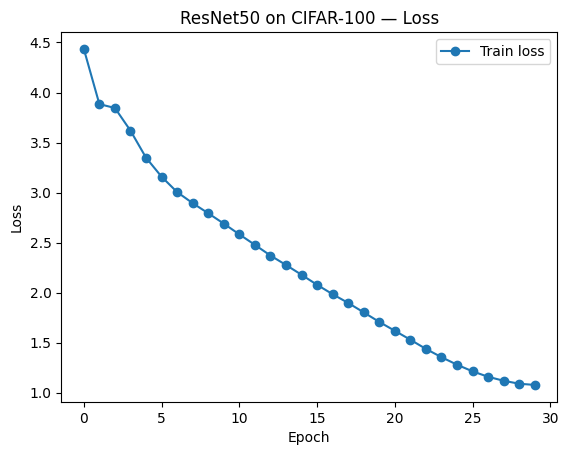

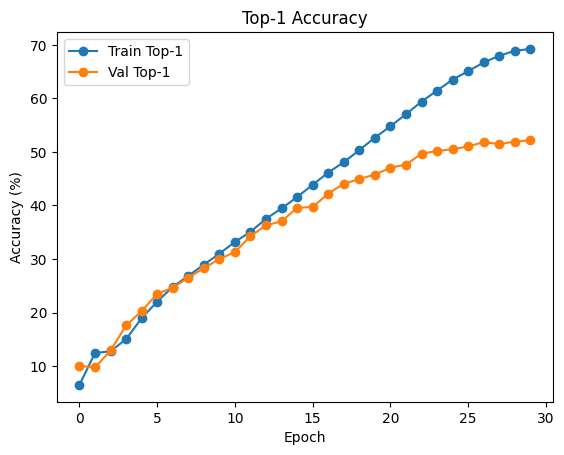

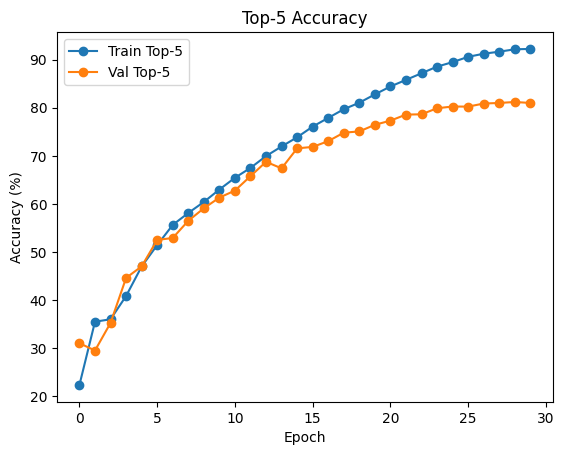

In [12]:
# Loss curves
plt.figure()
plt.plot(train_losses, marker="o", label="Train loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ResNet50 on CIFAR-100 — Loss")
plt.legend()
plt.show()

# Accuracy curves
plt.figure()
plt.plot(train_top1s, marker="o", label="Train Top-1")
plt.plot(val_top1s, marker="o", label="Val Top-1")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Top-1 Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_top5s, marker="o", label="Train Top-5")
plt.plot(val_top5s, marker="o", label="Val Top-5")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Top-5 Accuracy")
plt.legend()
plt.show()

## 8. Test-set Evaluation
Report final performance on the held-out test set (Top-1 / Top-5).


In [10]:
test_loss, test_top1, test_top5 = validate(model, test_loader, criterion, device)
print(f"Test loss: {test_loss:.4f} | Top-1: {test_top1:.2f}% | Top-5: {test_top5:.2f}%")

Test loss: 1.7137 | Top-1: 54.54% | Top-5: 82.36%


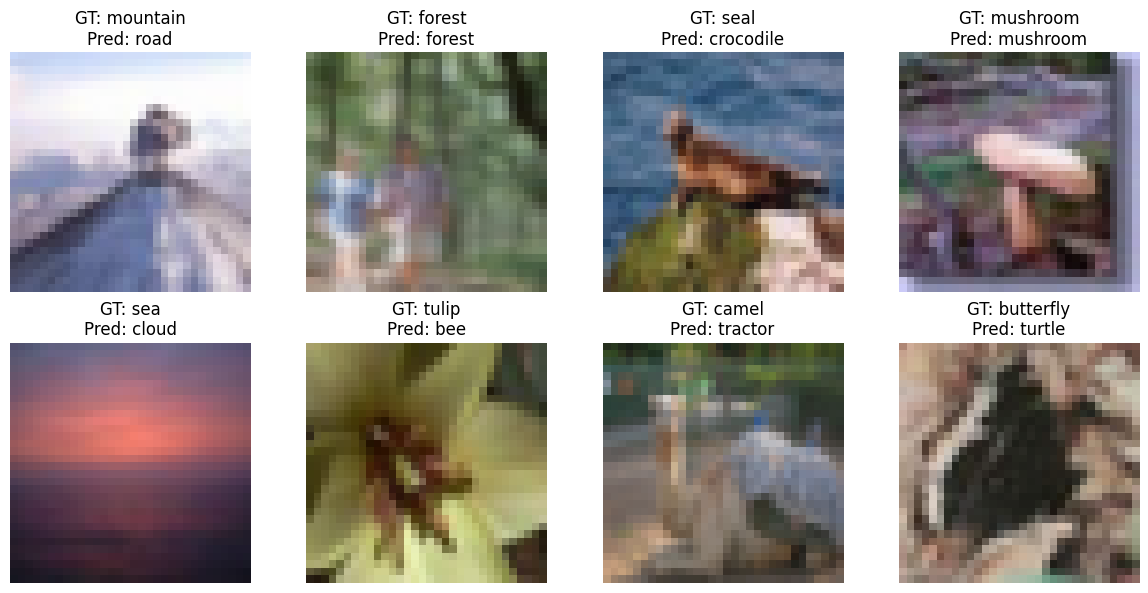

In [11]:
# Class names for CIFAR-100
classes = CIFAR100(root=DATA_DIR, train=False, download=False).classes


@torch.no_grad()
def show_predictions(model, loader, n_show=8):
    model.eval()
    images, targets = next(iter(loader))
    images = images.to(device)
    logits = model(images)
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    images_np = images.cpu().numpy()

    # Undo normalization for visualization
    mean = np.array(CIFAR100_MEAN).reshape(3, 1, 1)
    std = np.array(CIFAR100_STD).reshape(3, 1, 1)

    n = min(n_show, images_np.shape[0])
    plt.figure(figsize=(12, 3 * math.ceil(n / 4)))
    for i in range(n):
        img = images_np[i] * std + mean
        img = np.clip(img, 0, 1)
        plt.subplot(math.ceil(n / 4), 4, i + 1)
        plt.imshow(np.transpose(img, (1, 2, 0)))
        gt = classes[int(targets[i].item())]
        pd = classes[int(preds[i])]
        plt.title(f"GT: {gt}\nPred: {pd}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


show_predictions(model, test_loader, n_show=8)